=================Multilayer Perceptrons=========================

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

In [2]:
# even with a single-hidden-layer network, given enough nodes (possibly absurdly many), and the right set of weights, we can model any function.

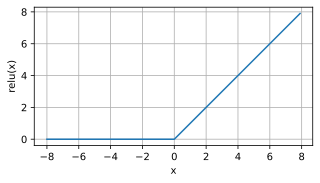

In [3]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

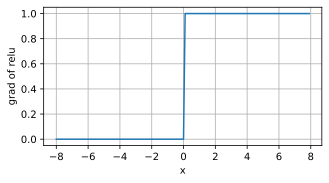

In [4]:
y.backward(torch.ones_like(x), retain_graph=True)
# y.backward(retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

#### 🔍 EXPLAINING y.backward(torch.ones_like(x), retain_graph=True)

##### 🔧 What happens during backward:
- Computes: dy/dx for each element
- Uses chain rule: grad_output * local_gradient
- grad_output = torch.ones_like(x) = [1, 1, 1, ...]
- local_gradient = derivative of relu
- Final gradient: x.grad = grad_output * d(relu)/dx

##### ⚡ Alternative approaches:

**For scalar loss (no gradient argument needed):**
```python
loss = y.sum()
loss.backward()  # ← No argument needed for scalar
```

**For vector output (gradient argument required):**
```python
y.backward(torch.ones_like(x))  # ← Current approach
```

##### 💡 Key Insights:
- Both methods give same result for uniform weighting
- `torch.ones_like(x)` means 'treat each output element equally'
- ReLU derivative: 1 if x > 0, else 0
- Final gradient shows ReLU derivative pattern

### PyTorch backward() Documentation: Scalar vs Non-Scalar Outputs

#### 1. Usual case: scalar output

If your output tensor is a scalar (single value, like a loss), you just call:

```python
loss.backward()
```

PyTorch computes $\frac{\partial loss}{\partial \theta}$ for every parameter $\theta$.

#### 2. Non-scalar output

If the output is **not a scalar** (e.g., a vector), PyTorch doesn't know which direction in that vector you want gradients for. You must supply the `gradient` parameter, which represents the gradient of some scalar function of the output with respect to that output.

In other words, if you have $y = f(x)$ and $y$ is a vector, you provide an external gradient $g$ to compute the vector-Jacobian product:

$$\text{backward}(g) \Rightarrow g^T \cdot J$$

where $J$ is the Jacobian of $g$ wrt $x$.

##### Key Points:
- **Scalar output**: No gradient argument needed - PyTorch knows what to do
- **Vector output**: Must provide gradient argument to specify which direction
- **`torch.ones_like(x)`**: Common choice meaning "treat all elements equally"
- **Vector-Jacobian product**: What actually gets computed for efficiency

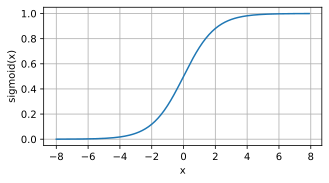

In [5]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

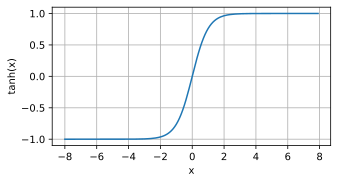

In [6]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

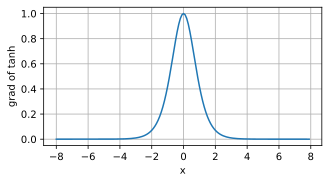

In [7]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

======================Implementation of Multilayer Perceptrons======================

In [8]:
import torch
from torch import nn
from d2l import torch as d2l

In [9]:
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))

In [10]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [11]:
@d2l.add_to_class(MLPScratch)
def forward(self, X):
    X = X.reshape((-1, self.num_inputs))
    H = relu(torch.matmul(X, self.W1) + self.b1)
    return torch.matmul(H, self.W2) + self.b2

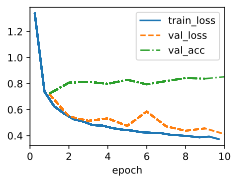

In [12]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [13]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens), nn.ReLU(), nn.LazyLinear(num_outputs))

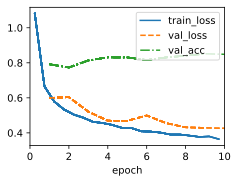

In [14]:
# MLP inherits the forward method from the Module class to simply invoke self.net(X) (X is input), which is now defined as a sequence of transformations via the Sequential class.
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

=================Forward Propagation, Backward Propagation, and Computational Graphs====================

In [15]:
# Forward Propagation
# Backward Propagation
# Computational Graphs

=====================Numerical Stability and Initialization========================

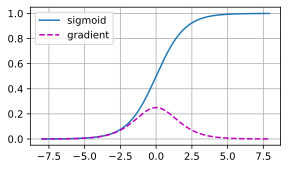

In [16]:
# Vanishing Gradients

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
# popular because it resembles a thresholding function. Since early artificial neural networks were inspired by biological neural networks, the idea of neurons that fire either fully or not at all (like biological neurons) seemed appealing
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

#  the sigmoid’s gradient vanishes both when its inputs are large and when they are small. Moreover, when backpropagating through many layers, unless we are in the Goldilocks zone, 
# where the inputs to many of the sigmoids are close to zero, the gradients of the overall product may vanish. When our network boasts many layers, unless we are careful, the gradient
#  will likely be cut off at some layer. Indeed, this problem used to plague deep network training. Consequently, ReLUs, which are more stable (but less neurally plausible), have 
# emerged as the default choice for practitioners

In [17]:
# Exploding Gradients

# 100 Gaussian random matrices and multiply them with some initial matrix.

M = torch.normal(0, 1, size=(4, 4))
print('a single matrix \n',M)
for i in range(100):
    M = M @ torch.normal(0, 1, size=(4, 4))
print('after multiplying 100 matrices\n', M)

a single matrix 
 tensor([[ 3.3891e-01, -2.1689e+00,  1.0464e+00, -3.5269e-01],
        [ 7.1616e-01,  5.3627e-01,  1.6654e+00, -9.5094e-01],
        [-1.1247e-01,  6.2457e-01, -1.3599e+00, -2.8686e-01],
        [-1.7702e-03,  8.7937e-01, -4.0574e-01,  1.2276e+00]])
after multiplying 100 matrices
 tensor([[ 1.2512e+25, -4.6864e+25, -9.3440e+24, -2.5989e+25],
        [ 1.8187e+24, -6.8121e+24, -1.3583e+24, -3.7777e+24],
        [-7.9926e+24,  2.9936e+25,  5.9690e+24,  1.6602e+25],
        [-1.6594e+24,  6.2153e+24,  1.2392e+24,  3.4467e+24]])


In [18]:
# Breaking the Symmetry

# If all weights are initialized to the same value, then all neurons in a given layer will produce the same output and receive the same gradient during backpropagation.
# dropout regularization would help.

# Parameter Initialization

## Default Initialization: random initialization

## Xavier Initialization: designed to keep the scale of the gradients roughly the same in all layers.

<small>

### Xavier Initialization - Mathematical Foundation

#### Problem: Scale Distribution Analysis

For a fully connected layer **without nonlinearities**, with $n_{in}$ inputs $x_j$ and weights $w_{ij}$:

$$o_i = \sum_{j=1}^{n_{in}} w_{ij}x_j \quad (5.4.3)$$

#### Assumptions:
- Weights $w_{ij}$ drawn independently from same distribution with zero mean and variance $\sigma^2$
- Inputs $x_j$ have zero mean and variance $\gamma^2$, independent of weights and each other

#### Key Derivations:

**Mean of output:**
$$E[o_i] = \sum_{j=1}^{n_{in}} E[w_{ij}x_j] = \sum_{j=1}^{n_{in}} E[w_{ij}]E[x_j] = 0 \quad (5.4.4)$$

**Variance of output:**
$$\text{Var}[o_i] = E[o_i^2] - (E[o_i])^2 = \sum_{j=1}^{n_{in}} E[w_{ij}^2x_j^2] = \sum_{j=1}^{n_{in}} E[w_{ij}^2]E[x_j^2] = n_{in}\sigma^2\gamma^2 \quad (5.4.5)$$

#### Xavier Condition:

**Forward propagation:** Keep variance fixed by setting $n_{in}\sigma^2 = 1$

**Backward propagation:** Similar reasoning gives $n_{out}\sigma^2 = 1$

**Compromise solution:**
$$\frac{1}{2}(n_{in} + n_{out})\sigma^2 = 1 \text{ or equivalently } \sigma = \sqrt{\frac{2}{n_{in} + n_{out}}} \quad (5.4.6)$$

#### Practical Implementation:

**Xavier Initialization** samples weights from Gaussian distribution:
$$\sigma^2 = \frac{2}{n_{in} + n_{out}}$$

Or equivalently, from uniform distribution $U(-a, a)$ where:
$$U\left(-\sqrt{\frac{6}{n_{in} + n_{out}}}, \sqrt{\frac{6}{n_{in} + n_{out}}}\right) \quad (5.4.7)$$

#### Key Insight:
Xavier initialization prevents gradients from vanishing or exploding by maintaining consistent variance across layers, though the nonlinearity assumption can be violated in practice (but still works well).

</small>

================Generalization in Deep Learning===========================

===============Dropout====================

###### 1. During training: dropout randomly “zeroes out” (drops) some activations in each layer with probability p. Then debiases each layer by normalizing by the fraction of nodes that were retained (not dropped out)

###### 2. Important: the mask (which neurons are dropped) is sampled independently for each input example, and for each layer.


![img](Images/dropout1.png)

In [ ]:
def dropout_layer(X, dropout): # X shape: (batch_size, num_features)
    assert 0 <= dropout <= 1
    if dropout == 1: return torch.zeros_like(X)
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [20]:
X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
print('dropout_p = 0:', dropout_layer(X, 0))
print('dropout_p = 0.5:', dropout_layer(X, 0.5))
print('dropout_p = 1:', dropout_layer(X, 1))

dropout_p = 0: tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
dropout_p = 0.5: tensor([[ 0.,  2.,  4.,  6.,  0., 10.,  0.,  0.],
        [16.,  0.,  0.,  0.,  0., 26., 28., 30.]])
dropout_p = 1: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [22]:
class DropoutMLPScratch(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = dropout_layer(H1, self.dropout_1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, self.dropout_2)
        return self.lin3(H2)

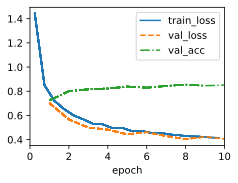

In [23]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}
model = DropoutMLPScratch(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [ ]:
# Concise implementation

class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(num_hiddens_1), nn.ReLU(), nn.Dropout(dropout_1), 
            nn.LazyLinear(num_hiddens_2), nn.ReLU(), nn.Dropout(dropout_2),
            nn.LazyLinear(num_outputs))
        
model = DropoutMLP(**hparams)
trainer.fit(model, data)

=====================Predicting House Prices on Kaggle============================

In [26]:
#  Jupyter notebook magic command that makes matplotlib plots display directly inside the notebook cells rather than opening in separate windows.
%matplotlib inline

import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
def download(url, folder, sha1_hash=None):
    """Download a file to folder and return the local filepath."""

def extract(filename, folder):
    """Extract a zip/tar file into folder."""

In [27]:
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


In [28]:
print(data.raw_train.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [32]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    # Remove the ID and label columns
    label = 'SalePrice'
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', label]),
         self.raw_val.drop(columns=['Id'])))
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes!='object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    # Replace discrete features by one-hot encoding
    features = pd.get_dummies(features, dummy_na=True)
    # Save preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

data.preprocess()
data.train.shape, data.train.iloc[:4, [0, 1, 2, 3, -3, -2, -1]]

((1460, 331),
    MSSubClass  LotFrontage   LotArea  OverallQual  SaleCondition_Partial  \
 0    0.067320    -0.184443 -0.217841     0.646073                  False   
 1   -0.873466     0.458096 -0.072032    -0.063174                  False   
 2    0.067320    -0.055935  0.137173     0.646073                  False   
 3    0.302516    -0.398622 -0.078371     0.646073                  False   
 
    SaleCondition_nan  SalePrice  
 0              False     208500  
 1              False     181500  
 2              False     223500  
 3              False     140000  )

In [33]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values.astype(float),
                                      dtype=torch.float32)
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
    return self.get_tensorloader(tensors, train)

In [ ]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        # data.train.drop(index=idx) - training data (everything EXCEPT the current fold)
        # data.train.loc[idx] - validation data (the current fold)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx), data.train.loc[idx]))
    return rets

def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    
    # The average validation error is returned when we train K times in the K-fold cross-validation.
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

c:\Users\huiya\pytorch-basics\.venv311\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
c:\Users\huiya\pytorch-basics\.venv311\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
c:\Users\huiya\pytorch-basics\.venv311\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
c:\Users\huiya\pytorch-basics\.venv311\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a

average validation log mse = 0.18273988008499148


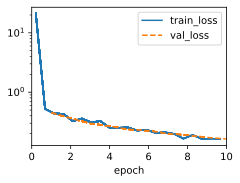

In [35]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)

In [39]:
# calculate the average predictions on the test set by all the models. 

preds = [model(torch.tensor(data.val.values.astype(float), dtype=torch.float32))
         for model in models]
len(preds), preds[0].shape


(5, torch.Size([1459, 1]))

In [40]:
torch.cat(preds, 1).shape

torch.Size([1459, 5])

In [ ]:
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('..//data//submission.csv', index=False)